# Football Metric Engineering

This notebook focuses on creating advanced football metrics from our event data. We'll implement metrics like Expected Threat (xT), PPDA (Passes Allowed Per Defensive Action), possession chains, and more to enable deeper tactical analysis.

## Approach

1. **Load Data**: Import the preprocessed dataset from previous steps
2. **Basic Metric Calculation**: Calculate key performance indicators
3. **Advanced Metric Engineering**: Implement sophisticated metrics like xT
4. **Validation**: Test the metrics on real match data
5. **Export**: Save the metrics functions and data for use in the API

Let's start by importing the necessary libraries and loading our dataset.

In [1]:
import os
import sys
import pickle
import json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from scipy import stats
import warnings

# For visualizing football pitch
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap

# Configure matplotlib
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 8]
warnings.filterwarnings('ignore')

# Import the FootballDataManager class
sys.path.append('/workspaces/football-insights-api')
try:
    from app.util.football_data_manager import FootballDataManager
except ImportError:
    print("Could not import FootballDataManager from app.util. Creating a simplified version.")
    # If module isn't found, let's recreate the minimum functionality needed
    from pathlib import Path
    import pickle
    
    class SimpleFootballDataManager:
        def __init__(self, cache_dir="data_cache"):
            self.cache_dir = Path(cache_dir)
            
        def load_analysis_dataset(self, dataset_path, load_data=True):
            """Load a previously saved analysis dataset"""
            dataset_dir = Path(dataset_path)
            if not dataset_dir.exists():
                raise ValueError(f"Dataset directory {dataset_path} does not exist")
                
            # Load summary
            with open(dataset_dir / 'summary.pkl', 'rb') as f:
                summary_data = pickle.load(f)
                
            # Initialize analysis data structure
            analysis_data = {
                'competitions': {},
                'summary': summary_data['summary']
            }
            
            # Load each competition
            competitions_dir = dataset_dir / 'competitions'
            for comp_id_dir in competitions_dir.iterdir():
                if not comp_id_dir.is_dir():
                    continue
                    
                comp_id = int(comp_id_dir.name)
                
                # Load competition metadata
                with open(comp_id_dir / 'metadata.pkl', 'rb') as f:
                    comp_meta = pickle.load(f)
                
                # Initialize competition data
                analysis_data['competitions'][comp_id] = {
                    'name': comp_meta['name'],
                    'season': comp_meta['season'],
                    'matches': {}
                }
                
                # Load matches
                matches_dir = comp_id_dir / 'matches'
                for match_id_dir in matches_dir.iterdir():
                    if not match_id_dir.is_dir():
                        continue
                        
                    match_id = int(match_id_dir.name)
                    
                    # Load match metadata
                    with open(match_id_dir / 'metadata.pkl', 'rb') as f:
                        match_meta = pickle.load(f)
                    
                    # Initialize match data with metadata
                    match_data = {
                        'home_team': match_meta['home_team'],
                        'away_team': match_meta['away_team'],
                        'score': match_meta['score'],
                        'has_360_data': match_meta['has_360_data']
                    }
                    
                    # Optionally load events and frames data
                    if load_data:
                        # Load events
                        with open(match_id_dir / 'events.pkl', 'rb') as f:
                            match_data['events'] = pickle.load(f)
                        
                        # Load freeze frames if available
                        if match_meta['has_360_data'] and (match_id_dir / 'frames.pkl').exists():
                            with open(match_id_dir / 'frames.pkl', 'rb') as f:
                                match_data['freeze_frames'] = pickle.load(f)
                    
                    # Add match data to competition
                    analysis_data['competitions'][comp_id]['matches'][match_id] = match_data
            
            return analysis_data

    # Use our simplified version instead
    FootballDataManager = SimpleFootballDataManager

## 1. Load Dataset

First, let's load the preprocessed dataset from our cache.

In [2]:
# Initialize the data manager
fdm = FootballDataManager()

# Path to the saved dataset
dataset_path = "data_cache/top_10_competitions"

# Check if the dataset exists
if not os.path.exists(dataset_path):
    print(f"Dataset not found at {dataset_path}. Please run the data preparation notebook first.")
else:
    # Load the dataset
    analysis_data = fdm.load_analysis_dataset(dataset_path, load_data=True)
    print(f"Dataset loaded successfully!")
    
    # Print summary
    summary = analysis_data['summary']
    print(f"\nDataset Summary:")
    print(f"Total Competitions: {summary['total_competitions']}")
    print(f"Total Matches: {summary['total_matches']}")
    print(f"Total Events: {summary['total_events']}")
    print(f"Matches with 360 data: {summary['matches_with_360']}")

OSError: [Errno 22] Invalid argument

Let's look at the competitions included in our dataset.

In [3]:
# Create a dataframe of competitions for easier analysis
competitions_data = []
for comp_id, comp_data in analysis_data['competitions'].items():
    comp_info = {
        'competition_id': comp_id,
        'name': comp_data['name'],
        'season': comp_data['season'],
        'num_matches': len(comp_data['matches']),
        'matches_with_360': sum(1 for m in comp_data['matches'].values() if m['has_360_data'])
    }
    competitions_data.append(comp_info)
    
competitions_df = pd.DataFrame(competitions_data)
print("Competitions in the dataset:")
competitions_df

Competitions in the dataset:


,competition_id,name,season,num_matches,matches_with_360
0,11,La Liga,2020/2021,3,0
1,43,FIFA World Cup,2022,3,3
2,44,Major League Soccer,2023,3,0
3,53,UEFA Women's Euro,2022,3,3
4,55,UEFA Euro,2020,3,3
5,7,Ligue 1,2021/2022,3,0
6,72,Women's World Cup,2023,3,3
7,9,1. Bundesliga,2023/2024,3,3


## 2. Basic Metric Calculations

Before moving to complex metrics, let's calculate some basic performance indicators per team and match. These will serve as building blocks for the advanced metrics.

In [4]:
def calculate_basic_match_metrics(events_df):
    """Calculate basic match metrics from events DataFrame"""
    teams = events_df['team'].unique()
    metrics = {}
    
    # Calculate metrics for each team
    for team in teams:
        team_events = events_df[events_df['team'] == team]
        opposition_events = events_df[events_df['team'] != team]
        
        # Possessions
        team_possessions = len(events_df[events_df['possession_team'] == team]['possession'].unique())
        total_possessions = len(events_df['possession'].unique())
        
        # Passes
        passes = team_events[team_events['type'] == 'Pass']
        successful_passes = passes[passes['pass_outcome'].isna()]
        
        # Shots
        shots = team_events[team_events['type'] == 'Shot']
        goals = shots[shots['shot_outcome'] == 'Goal']
        on_target = shots[shots['shot_outcome'].isin(['Goal', 'Saved'])]
        
        # Defensive actions
        pressures = team_events[team_events['type'] == 'Pressure']
        tackles = team_events[team_events['type'] == 'Duel']
        interceptions = team_events[team_events['type'] == 'Interception']
        
        # Calculate PPDA (Passes allowed per defensive action in opposition half)
        opp_passes_own_half = opposition_events[
            (opposition_events['type'] == 'Pass') & 
            (opposition_events['location'].apply(lambda x: x[0] < 60 if isinstance(x, list) and len(x) >= 2 else False))
        ]
        
        def_actions_opp_half = team_events[
            (team_events['type'].isin(['Pressure', 'Duel', 'Interception'])) & 
            (team_events['location'].apply(lambda x: x[0] >= 60 if isinstance(x, list) and len(x) >= 2 else False))
        ]
        
        ppda = len(opp_passes_own_half) / max(len(def_actions_opp_half), 1)  # Avoid division by zero
        
        # Store metrics
        metrics[team] = {
            'possession_pct': team_possessions / total_possessions * 100 if total_possessions > 0 else 0,
            'passes_attempted': len(passes),
            'passes_completed': len(successful_passes),
            'pass_completion': len(successful_passes) / len(passes) * 100 if len(passes) > 0 else 0,
            'shots': len(shots),
            'goals': len(goals),
            'shots_on_target': len(on_target),
            'xg': shots['shot_statsbomb_xg'].sum(),
            'pressures': len(pressures),
            'tackles': len(tackles),
            'interceptions': len(interceptions),
            'ppda': ppda
        }
    
    return metrics

# Create a list to store match metrics
match_metrics = []

# Process matches to calculate basic metrics
for comp_id, comp_data in analysis_data['competitions'].items():
    for match_id, match_data in comp_data['matches'].items():
        if 'events' in match_data:
            # Calculate metrics for this match
            events_df = match_data['events']
            metrics = calculate_basic_match_metrics(events_df)
            
            # Store metrics with match context
            home_team = match_data['home_team']
            away_team = match_data['away_team']
            
            # Check if both teams' metrics were calculated
            if home_team in metrics and away_team in metrics:
                match_metrics.append({
                    'match_id': match_id,
                    'competition_id': comp_id,
                    'competition_name': comp_data['name'],
                    'home_team': home_team,
                    'away_team': away_team,
                    'score': match_data['score'],
                    'home_metrics': metrics[home_team],
                    'away_metrics': metrics[away_team],
                })

# Convert to DataFrame for easier analysis
if match_metrics:
    print(f"Calculated metrics for {len(match_metrics)} matches")
    
    # Display summary of a sample match
    sample_match = match_metrics[0]
    print(f"\nSample match metrics - {sample_match['home_team']} vs {sample_match['away_team']} ({sample_match['score']})")
    print(f"\nHome team ({sample_match['home_team']}) metrics:")
    for metric, value in sample_match['home_metrics'].items():
        print(f"{metric}: {value:.2f}")
    
    print(f"\nAway team ({sample_match['away_team']}) metrics:")
    for metric, value in sample_match['away_metrics'].items():
        print(f"{metric}: {value:.2f}")
else:
    print("No match metrics could be calculated.")

Calculated metrics for 24 matches

Sample match metrics - Deportivo Alavés vs Barcelona (1-1)

Home team (Deportivo Alavés) metrics:
possession_pct: 42.07
passes_attempted: 238.00
passes_completed: 154.00
pass_completion: 64.71
shots: 4.00
goals: 1.00
shots_on_target: 3.00
xg: 1.13
pressures: 222.00
tackles: 33.00
interceptions: 10.00
ppda: 4.44

Away team (Barcelona) metrics:
possession_pct: 57.93
passes_attempted: 880.00
passes_completed: 784.00
pass_completion: 89.09
shots: 25.00
goals: 1.00
shots_on_target: 8.00
xg: 2.09
pressures: 85.00
tackles: 30.00
interceptions: 4.00
ppda: 2.37


## 3. Advanced Metric Engineering

Now let's implement some advanced metrics that provide deeper insights into team performance.

### 3.1 Expected Threat (xT) Model

Expected Threat (xT) is a model that assigns a value to each location on the pitch based on the probability that a possession from that location will result in a goal. We'll implement a simplified grid-based xT model.

In [5]:
class ExpectedThreatModel:
    """A grid-based Expected Threat (xT) model."""
    
    def __init__(self, n_grid_cells_x=12, n_grid_cells_y=8):
        """Initialize the xT model with grid dimensions."""
        self.n_grid_cells_x = n_grid_cells_x
        self.n_grid_cells_y = n_grid_cells_y
        self.cell_length_x = 120 / n_grid_cells_x
        self.cell_length_y = 80 / n_grid_cells_y
        self.grid = np.zeros((n_grid_cells_x, n_grid_cells_y))
        self.is_trained = False
    
    def _get_cell_indices(self, x, y):
        """Convert pitch coordinates to grid cell indices."""
        # Ensure coordinates are within pitch boundaries
        x = max(0, min(119.9, x))
        y = max(0, min(79.9, y))
        
        # Calculate cell indices
        i = int(x / self.cell_length_x)
        j = int(y / self.cell_length_y)
        
        return i, j
    
    def train(self, events_df):
        """Train the xT model using event data."""
        # Initialize counters for shots and goals from each cell
        move_counts = np.zeros((self.n_grid_cells_x, self.n_grid_cells_y, self.n_grid_cells_x, self.n_grid_cells_y))
        shot_counts = np.zeros((self.n_grid_cells_x, self.n_grid_cells_y))
        goal_counts = np.zeros((self.n_grid_cells_x, self.n_grid_cells_y))
        cell_count = np.zeros((self.n_grid_cells_x, self.n_grid_cells_y))
        
        # Count shots and goals from each cell
        for _, event in events_df[events_df['type'] == 'Shot'].iterrows():
            if isinstance(event['location'], list) and len(event['location']) >= 2:
                x, y = event['location'][0], event['location'][1]
                i, j = self._get_cell_indices(x, y)
                
                shot_counts[i, j] += 1
                cell_count[i, j] += 1
                
                if event['shot_outcome'] == 'Goal':
                    goal_counts[i, j] += 1
        
        # Count moves between cells (passes, carries)
        for _, event in events_df[(events_df['type'] == 'Pass') | (events_df['type'] == 'Carry')].iterrows():
            if isinstance(event['location'], list) and len(event['location']) >= 2:
                start_x, start_y = event['location'][0], event['location'][1]
                
                # Get end location based on event type
                end_loc = None
                if event['type'] == 'Pass' and isinstance(event['pass_end_location'], list):
                    end_loc = event['pass_end_location']
                elif event['type'] == 'Carry' and isinstance(event['carry_end_location'], list):
                    end_loc = event['carry_end_location']
                
                if end_loc and len(end_loc) >= 2:
                    end_x, end_y = end_loc[0], end_loc[1]
                    
                    # Get cell indices
                    i_start, j_start = self._get_cell_indices(start_x, start_y)
                    i_end, j_end = self._get_cell_indices(end_x, end_y)
                    
                    # Increment move count
                    move_counts[i_start, j_start, i_end, j_end] += 1
                    cell_count[i_start, j_start] += 1
        
        # Calculate shot probability for each cell
        shot_probability = np.zeros((self.n_grid_cells_x, self.n_grid_cells_y))
        for i in range(self.n_grid_cells_x):
            for j in range(self.n_grid_cells_y):
                if cell_count[i, j] > 0:
                    shot_probability[i, j] = shot_counts[i, j] / cell_count[i, j]
        
        # Calculate goal probability given a shot
        goal_given_shot = np.zeros((self.n_grid_cells_x, self.n_grid_cells_y))
        for i in range(self.n_grid_cells_x):
            for j in range(self.n_grid_cells_y):
                if shot_counts[i, j] > 0:
                    goal_given_shot[i, j] = goal_counts[i, j] / shot_counts[i, j]
        
        # Calculate move probability matrix
        move_probability = np.zeros((self.n_grid_cells_x, self.n_grid_cells_y, self.n_grid_cells_x, self.n_grid_cells_y))
        for i_start in range(self.n_grid_cells_x):
            for j_start in range(self.n_grid_cells_y):
                if cell_count[i_start, j_start] > 0:
                    for i_end in range(self.n_grid_cells_x):
                        for j_end in range(self.n_grid_cells_y):
                            move_probability[i_start, j_start, i_end, j_end] = (
                                move_counts[i_start, j_start, i_end, j_end] / cell_count[i_start, j_start]
                            )
        
        # Initialize xT grid with direct shot value (probability of shot * probability of goal given shot)
        self.grid = shot_probability * goal_given_shot
        
        # Use dynamic programming to calculate expected threat for each cell
        for _ in range(5):  # Iterate a few times to converge
            new_grid = np.copy(self.grid)
            
            for i in range(self.n_grid_cells_x):
                for j in range(self.n_grid_cells_y):
                    # Direct value from shooting
                    direct_value = shot_probability[i, j] * goal_given_shot[i, j]
                    
                    # Value from moving to other cells
                    move_value = 0
                    for i_end in range(self.n_grid_cells_x):
                        for j_end in range(self.n_grid_cells_y):
                            move_value += move_probability[i, j, i_end, j_end] * self.grid[i_end, j_end]
                    
                    # Total value is max of direct value and move value
                    new_grid[i, j] = max(direct_value, move_value)
            
            self.grid = new_grid
        
        self.is_trained = True
        return self.grid
    
    def get_value(self, x, y):
        """Get the xT value for a location on the pitch."""
        if not self.is_trained:
            raise ValueError("Model must be trained before getting values")
        
        i, j = self._get_cell_indices(x, y)
        return self.grid[i, j]
    
    def calculate_move_value(self, start_x, start_y, end_x, end_y):
        """Calculate the value added by moving from one location to another."""
        if not self.is_trained:
            raise ValueError("Model must be trained before calculating move values")
        
        i_start, j_start = self._get_cell_indices(start_x, start_y)
        i_end, j_end = self._get_cell_indices(end_x, end_y)
        
        # Value added is the difference in xT between the end and start locations
        return self.grid[i_end, j_end] - self.grid[i_start, j_start]
    
    def visualize_grid(self, ax=None, title="Expected Threat (xT) Model", colorbar=True):
        """Visualize the xT grid as a heatmap on a football pitch."""
        if not self.is_trained:
            raise ValueError("Model must be trained before visualizing")
        
        if ax is None:
            fig, ax = plt.subplots(figsize=(12, 8))
        
        # Create a pitch
        from mplsoccer.pitch import Pitch
        try:
            pitch = Pitch(pitch_type='statsbomb', pitch_color='#22312b', line_color='white', line_zorder=2)
            pitch.draw(ax=ax)
        except:
            # If mplsoccer isn't available, draw a simple pitch
            ax.set_xlim([0, 120])
            ax.set_ylim([0, 80])
            ax.set_facecolor('#22312b')
            
            # Outline
            ax.plot([0, 0, 120, 120, 0], [0, 80, 80, 0, 0], color='white')
            
            # Halfway line
            ax.plot([60, 60], [0, 80], color='white')
            ax.add_patch(plt.Circle((60, 40), 9.15, facecolor='none', edgecolor='white'))
            
            # Penalty areas
            ax.plot([0, 18, 18, 0], [18, 18, 62, 62], color='white')
            ax.plot([120, 102, 102, 120], [18, 18, 62, 62], color='white')
        
        # Create coordinates for the grid centers
        x_centers = np.linspace(self.cell_length_x/2, 120 - self.cell_length_x/2, self.n_grid_cells_x)
        y_centers = np.linspace(self.cell_length_y/2, 80 - self.cell_length_y/2, self.n_grid_cells_y)
        
        # Create mesh grid
        X, Y = np.meshgrid(x_centers, y_centers)
        
        # Transpose grid for correct orientation
        Z = self.grid.T
        
        # Plot heatmap
        pcm = ax.pcolormesh(np.linspace(0, 120, self.n_grid_cells_x + 1),
                           np.linspace(0, 80, self.n_grid_cells_y + 1),
                           Z, shading='auto', alpha=0.8, cmap='viridis', zorder=1)
        
        if colorbar:
            plt.colorbar(pcm, ax=ax, label='xT Value')
        
        ax.set_title(title)
        ax.set_xlabel('Pitch Position (X)')
        ax.set_ylabel('Pitch Position (Y)')
        
        return ax

Combined 24 matches with 89923 events for xT training


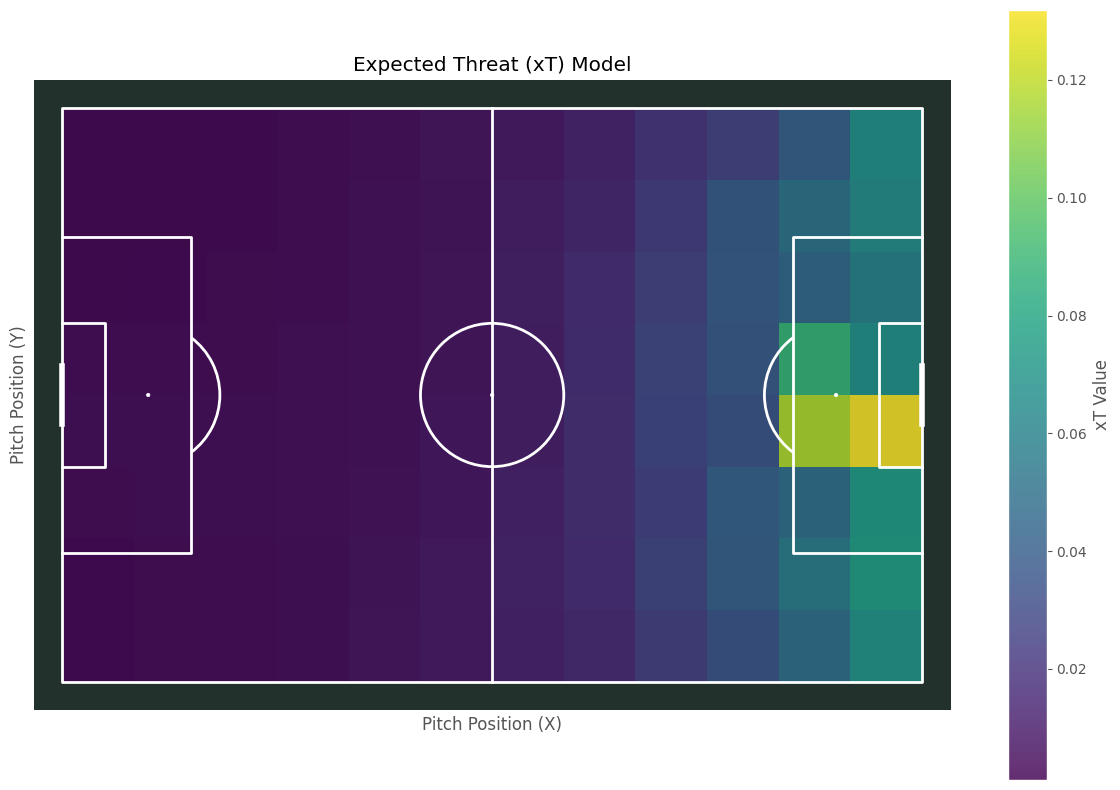

In [6]:
# Collect all event data for training the xT model
all_events = []

for comp_id, comp_data in analysis_data['competitions'].items():
    for match_id, match_data in comp_data['matches'].items():
        if 'events' in match_data:
            events_df = match_data['events']
            all_events.append(events_df)

# Combine all events into a single DataFrame
if all_events:
    full_events_df = pd.concat(all_events)
    print(f"Combined {len(all_events)} matches with {len(full_events_df)} events for xT training")
    
    # Train the xT model
    xt_model = ExpectedThreatModel(n_grid_cells_x=12, n_grid_cells_y=8)
    xt_grid = xt_model.train(full_events_df)
    
    # Visualize the xT model
    plt.figure(figsize=(12, 8))
    ax = plt.gca()
    xt_model.visualize_grid(ax=ax, title="Expected Threat (xT) Model")
    plt.tight_layout()
    plt.show()
else:
    print("No events found for xT model training.")

### 3.2 Calculate xT Added by Player Actions

Now that we have an xT model, let's use it to calculate the xT added by player actions (passes and carries).

In [7]:
def calculate_xt_added(events_df, xt_model):
    """Calculate the xT added by each action in the events DataFrame."""
    events_with_xt = events_df.copy()
    events_with_xt['xt_start'] = 0.0
    events_with_xt['xt_end'] = 0.0
    events_with_xt['xt_added'] = 0.0
    
    # Calculate xT values for passes and carries
    for idx, event in events_df.iterrows():
        if event['type'] in ['Pass', 'Carry']:
            # Get start location
            if isinstance(event['location'], list) and len(event['location']) >= 2:
                start_x, start_y = event['location'][0], event['location'][1]
                xt_start = xt_model.get_value(start_x, start_y)
                events_with_xt.loc[idx, 'xt_start'] = xt_start
                
                # Get end location based on event type
                end_loc = None
                if event['type'] == 'Pass' and isinstance(event['pass_end_location'], list):
                    end_loc = event['pass_end_location']
                elif event['type'] == 'Carry' and isinstance(event['carry_end_location'], list):
                    end_loc = event['carry_end_location']
                
                if end_loc and len(end_loc) >= 2:
                    end_x, end_y = end_loc[0], end_loc[1]
                    xt_end = xt_model.get_value(end_x, end_y)
                    events_with_xt.loc[idx, 'xt_end'] = xt_end
                    
                    # Calculate xT added
                    xt_added = xt_end - xt_start
                    events_with_xt.loc[idx, 'xt_added'] = xt_added
    
    return events_with_xt

# Calculate xT added for a sample match
sample_match = None
for comp_id, comp_data in analysis_data['competitions'].items():
    for match_id, match_data in comp_data['matches'].items():
        if 'events' in match_data:
            sample_match = match_data
            break
    if sample_match:
        break

if sample_match:
    events_df = sample_match['events']
    events_with_xt = calculate_xt_added(events_df, xt_model)
    
    print(f"Sample match: {sample_match['home_team']} vs {sample_match['away_team']} ({sample_match['score']})")
    
    # Show top actions by xT added
    top_actions = events_with_xt.sort_values('xt_added', ascending=False).head(10)
    print("\nTop 10 actions by xT added:")
    for _, action in top_actions.iterrows():
        print(f"{action['player']} ({action['team']}) - {action['type']} - xT added: {action['xt_added']:.4f} - Minute: {action['minute']}")

Sample match: Deportivo Alavés vs Barcelona (1-1)

Top 10 actions by xT added:
Joaquín Navarro Jiménez (Deportivo Alavés) - Pass - xT added: 0.1242 - Minute: 23
Florian Grégoire Claude Lejeune (Deportivo Alavés) - Pass - xT added: 0.1129 - Minute: 40
Pedro González López (Barcelona) - Pass - xT added: 0.1034 - Minute: 83
Pedro González López (Barcelona) - Pass - xT added: 0.0994 - Minute: 66
Miralem Pjanić (Barcelona) - Pass - xT added: 0.0939 - Minute: 52
Lionel Andrés Messi Cuccittini (Barcelona) - Carry - xT added: 0.0893 - Minute: 28
Miralem Pjanić (Barcelona) - Pass - xT added: 0.0840 - Minute: 91
Frenkie de Jong (Barcelona) - Pass - xT added: 0.0831 - Minute: 41
Anssumane Fati (Barcelona) - Pass - xT added: 0.0796 - Minute: 69
Antoine Griezmann (Barcelona) - Pass - xT added: 0.0796 - Minute: 53


### 3.3 Player xT Contributions

Let's calculate the total xT contribution by player across all matches.

In [8]:
# Calculate xT contributions for all matches
player_xt_contributions = defaultdict(float)
player_xt_count = defaultdict(int)
player_teams = {}

for comp_id, comp_data in analysis_data['competitions'].items():
    for match_id, match_data in comp_data['matches'].items():
        if 'events' in match_data:
            events_df = match_data['events']
            events_with_xt = calculate_xt_added(events_df, xt_model)
            
            # Aggregate by player
            for _, event in events_with_xt.iterrows():
                if pd.notna(event['player']) and event['xt_added'] > 0:
                    player_name = event['player']
                    player_xt_contributions[player_name] += event['xt_added']
                    player_xt_count[player_name] += 1
                    player_teams[player_name] = event['team']

# Convert to DataFrame
player_xt_data = []
for player, xt_sum in player_xt_contributions.items():
    count = player_xt_count[player]
    team = player_teams.get(player, 'Unknown')
    player_xt_data.append({
        'player': player,
        'team': team,
        'total_xt_added': xt_sum,
        'positive_actions': count,
        'avg_xt_per_action': xt_sum / count if count > 0 else 0
    })

player_xt_df = pd.DataFrame(player_xt_data)
print(f"xT contributions calculated for {len(player_xt_df)} players")

# Show top players by total xT added
print("\nTop 10 players by total xT added:")
top_players_xt = player_xt_df.sort_values('total_xt_added', ascending=False).head(10)
print(top_players_xt[['player', 'team', 'total_xt_added', 'positive_actions', 'avg_xt_per_action']])

# Show top players by average xT per action (minimum 10 actions)
print("\nTop 10 players by average xT per action (minimum 10 actions):")
top_players_avg_xt = player_xt_df[player_xt_df['positive_actions'] >= 10].sort_values('avg_xt_per_action', ascending=False).head(10)
print(top_players_avg_xt[['player', 'team', 'avg_xt_per_action', 'positive_actions', 'total_xt_added']])

xT contributions calculated for 508 players

Top 10 players by total xT added:
                             player                 team  total_xt_added  \
3    Lionel Andrés Messi Cuccittini  Paris Saint-Germain        6.715935   
7          Sergio Busquets i Burgos                Spain        3.084784   
1                  Jordi Alba Ramos                Spain        2.807205   
294                  Marco Verratti  Paris Saint-Germain        2.554170   
85                     Granit Xhaka     Bayer Leverkusen        2.028627   
22             Pedro González López                Spain        1.961397   
220                Kosovare Asllani       Sweden Women's        1.855455   
227                 Fridolina Rolfö       Sweden Women's        1.818805   
257                     Lucy Bronze      England Women's        1.801820   
359            Kylian Mbappé Lottin  Paris Saint-Germain        1.760536   

     positive_actions  avg_xt_per_action  
3                 481           0.013962 

### 3.4 PPDA (Passes Allowed Per Defensive Action)

PPDA is a metric used to measure the intensity of a team's press. A lower PPDA indicates a more aggressive pressing style, as the opposition is allowed fewer passes before a defensive action occurs.

Let's implement a function to calculate PPDA.

In [9]:
def calculate_ppda(events_df, team, opposition_half_only=True):
    """Calculate PPDA (Passes Allowed Per Defensive Action) for a team.
    
    Args:
        events_df: DataFrame of match events
        team: Team to calculate PPDA for
        opposition_half_only: If True, only consider defensive actions in the opposition half
        
    Returns:
        PPDA value
    """
    # Get opposition team
    teams = events_df['team'].unique()
    opposition_team = [t for t in teams if t != team][0] if len(teams) > 1 else None
    
    if not opposition_team:
        return None
    
    # Get opposition passes
    opposition_passes = events_df[(events_df['team'] == opposition_team) & (events_df['type'] == 'Pass')]
    
    # Filter passes to only those in team's defensive half if opposition_half_only=True
    if opposition_half_only:
        # For the opposition, their attacking half is the team's defensive half
        opposition_passes = opposition_passes[
            opposition_passes['location'].apply(
                lambda x: x[0] >= 60 if isinstance(x, list) and len(x) >= 2 else False
            )
        ]
    
    # Get defensive actions by team
    defensive_actions = events_df[
        (events_df['team'] == team) &
        (events_df['type'].isin(['Pressure', 'Duel', 'Interception']))
    ]
    
    # Filter defensive actions to only those in opposition half if opposition_half_only=True
    if opposition_half_only:
        defensive_actions = defensive_actions[
            defensive_actions['location'].apply(
                lambda x: x[0] >= 60 if isinstance(x, list) and len(x) >= 2 else False
            )
        ]
    
    # Calculate PPDA
    num_opposition_passes = len(opposition_passes)
    num_defensive_actions = len(defensive_actions)
    
    ppda = num_opposition_passes / num_defensive_actions if num_defensive_actions > 0 else float('inf')
    
    return ppda

# Calculate PPDA for teams in a sample match
if sample_match:
    events_df = sample_match['events']
    teams = events_df['team'].unique()
    
    print(f"Sample match: {sample_match['home_team']} vs {sample_match['away_team']} ({sample_match['score']})")
    
    for team in teams:
        ppda = calculate_ppda(events_df, team)
        print(f"{team} PPDA: {ppda:.2f}")

Sample match: Deportivo Alavés vs Barcelona (1-1)
Deportivo Alavés PPDA: 9.52
Barcelona PPDA: 1.13


### 3.5 Progressive Passes

Progressive passes are passes that move the ball significantly toward the opponent's goal. Let's identify and analyze these passes.

In [10]:
def identify_progressive_passes(events_df, distance_threshold=10):
    """Identify progressive passes in the events DataFrame.
    
    Args:
        events_df: DataFrame of match events
        distance_threshold: Minimum distance (in meters) the pass must progress toward goal
        
    Returns:
        DataFrame of progressive passes
    """
    # Filter for passes only
    passes = events_df[events_df['type'] == 'Pass'].copy()
    
    # Calculate forward progression
    progressive_passes = []
    
    for idx, pass_event in passes.iterrows():
        if isinstance(pass_event['location'], list) and isinstance(pass_event['pass_end_location'], list):
            start_x = pass_event['location'][0]
            end_x = pass_event['pass_end_location'][0]
            
            # Calculate forward progression
            progression = end_x - start_x
            
            if progression >= distance_threshold:
                pass_event['progression'] = progression
                progressive_passes.append(pass_event)
    
    if progressive_passes:
        progressive_df = pd.DataFrame(progressive_passes)
        return progressive_df
    else:
        return pd.DataFrame()

# Identify progressive passes in a sample match
if sample_match:
    events_df = sample_match['events']
    progressive_passes = identify_progressive_passes(events_df, distance_threshold=10)
    
    print(f"Sample match: {sample_match['home_team']} vs {sample_match['away_team']} ({sample_match['score']})")
    print(f"Found {len(progressive_passes)} progressive passes out of {len(events_df[events_df['type'] == 'Pass'])} total passes")
    
    # Count progressive passes by player
    player_prog_passes = progressive_passes.groupby(['player', 'team']).size().reset_index(name='progressive_passes')
    player_prog_passes = player_prog_passes.sort_values('progressive_passes', ascending=False).head(10)
    
    print("\nTop 10 players by progressive passes:")
    print(player_prog_passes)

Sample match: Deportivo Alavés vs Barcelona (1-1)
Found 306 progressive passes out of 1118 total passes

Top 10 players by progressive passes:
                            player              team  progressive_passes
8                  Frenkie de Jong         Barcelona                  29
24          Sergi Roberto Carnicer         Barcelona                  22
18                  Miralem Pjanić         Barcelona                  20
23            Rubén Duarte Sánchez  Deportivo Alavés                  19
9            Gerard Piqué Bernabéu         Barcelona                  19
2                  Clément Lenglet         Barcelona                  19
14  Lionel Andrés Messi Cuccittini         Barcelona                  18
5          Fernando Pacheco Flores  Deportivo Alavés                  18
19            Norberto Murara Neto         Barcelona                  15
26        Sergio Busquets i Burgos         Barcelona                  13


## 4. Visualizations for Football API

In this section, we'll create visualizations that can be exported through our API endpoints. We'll focus on creating plots that demonstrate:

1. Expected Threat (xT) maps
2. Player comparison visualizations
3. Matchup analysis charts
4. Positional analysis visualizations

These visualizations will serve as templates for what the API can provide to frontend applications.

In [ ]:
# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.patches import Arc
import matplotlib.colors as mcolors
import json
import io
import base64
from matplotlib.colors import LinearSegmentedColormap

from pathlib import Path

export_dir = Path("data_cache/exported_visualizations")

# Function to convert plots to base64 for API response
def fig_to_base64(fig):
    """Convert matplotlib figure to base64 string for embedding in web pages"""
    buf = io.BytesIO()
    fig.savefig(buf, format='png', dpi=100, bbox_inches='tight')
    buf.seek(0)
    img_str = base64.b64encode(buf.read()).decode('utf-8')
    return img_str

# Create a football pitch drawing function that matches our API's coordinate system
def draw_pitch(ax, pitch_color='#22312b', line_color='white', line_width=2):
    """
    Draw a football pitch on the given axes
    Uses the same coordinate system as our API (0-120 x 0-80)
    """
    # Pitch dimensions
    pitch_length = 120
    pitch_width = 80
    
    # Set background color
    ax.set_facecolor(pitch_color)
    
    # Draw pitch outline
    ax.plot([0, 0], [0, pitch_width], color=line_color, lw=line_width)
    ax.plot([0, pitch_length], [pitch_width, pitch_width], color=line_color, lw=line_width)
    ax.plot([pitch_length, pitch_length], [pitch_width, 0], color=line_color, lw=line_width)
    ax.plot([pitch_length, 0], [0, 0], color=line_color, lw=line_width)
    
    # Halfway line
    ax.plot([pitch_length/2, pitch_length/2], [0, pitch_width], color=line_color, lw=line_width)
    
    # Center circle
    center_circle = plt.Circle((pitch_length/2, pitch_width/2), 9.15, color=line_color, fill=False, lw=line_width)
    ax.add_patch(center_circle)
    center_spot = plt.Circle((pitch_length/2, pitch_width/2), 0.8, color=line_color, lw=line_width)
    ax.add_patch(center_spot)
    
    # Penalty areas
    # Left penalty area
    ax.plot([18, 18], [pitch_width/2 - 22, pitch_width/2 + 22], color=line_color, lw=line_width)
    ax.plot([0, 18], [pitch_width/2 - 22, pitch_width/2 - 22], color=line_color, lw=line_width)
    ax.plot([18, 0], [pitch_width/2 + 22, pitch_width/2 + 22], color=line_color, lw=line_width)
    
    # Right penalty area
    ax.plot([pitch_length - 18, pitch_length - 18], [pitch_width/2 - 22, pitch_width/2 + 22], color=line_color, lw=line_width)
    ax.plot([pitch_length, pitch_length - 18], [pitch_width/2 - 22, pitch_width/2 - 22], color=line_color, lw=line_width)
    ax.plot([pitch_length - 18, pitch_length], [pitch_width/2 + 22, pitch_width/2 + 22], color=line_color, lw=line_width)
    
    # Goal areas
    # Left goal area
    ax.plot([6, 6], [pitch_width/2 - 9.16, pitch_width/2 + 9.16], color=line_color, lw=line_width)
    ax.plot([0, 6], [pitch_width/2 - 9.16, pitch_width/2 - 9.16], color=line_color, lw=line_width)
    ax.plot([6, 0], [pitch_width/2 + 9.16, pitch_width/2 + 9.16], color=line_color, lw=line_width)
    
    # Right goal area
    ax.plot([pitch_length - 6, pitch_length - 6], [pitch_width/2 - 9.16, pitch_width/2 + 9.16], color=line_color, lw=line_width)
    ax.plot([pitch_length, pitch_length - 6], [pitch_width/2 - 9.16, pitch_width/2 - 9.16], color=line_color, lw=line_width)
    ax.plot([pitch_length - 6, pitch_length], [pitch_width/2 + 9.16, pitch_width/2 + 9.16], color=line_color, lw=line_width)
    
    # Penalty spots
    penalty_spot_left = plt.Circle((11, pitch_width/2), 0.8, color=line_color, lw=line_width)
    penalty_spot_right = plt.Circle((pitch_length - 11, pitch_width/2), 0.8, color=line_color, lw=line_width)
    ax.add_patch(penalty_spot_left)
    ax.add_patch(penalty_spot_right)
    
    # Penalty arcs
    left_arc = Arc((11, pitch_width/2), height=18.3, width=18.3, angle=0, theta1=310, theta2=50, color=line_color, lw=line_width)
    right_arc = Arc((pitch_length - 11, pitch_width/2), height=18.3, width=18.3, angle=0, theta1=130, theta2=230, color=line_color, lw=line_width)
    ax.add_patch(left_arc)
    ax.add_patch(right_arc)
    
    # Remove axis ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([-5, pitch_length+5])
    ax.set_ylim([-5, pitch_width+5])
    ax.set_aspect('equal')
    
    return ax

## 1. Expected Threat (xT) Visualizations

Let's create visualizations that showcase the Expected Threat model we built. These can be exported through the `/xt-analytics` API endpoints.

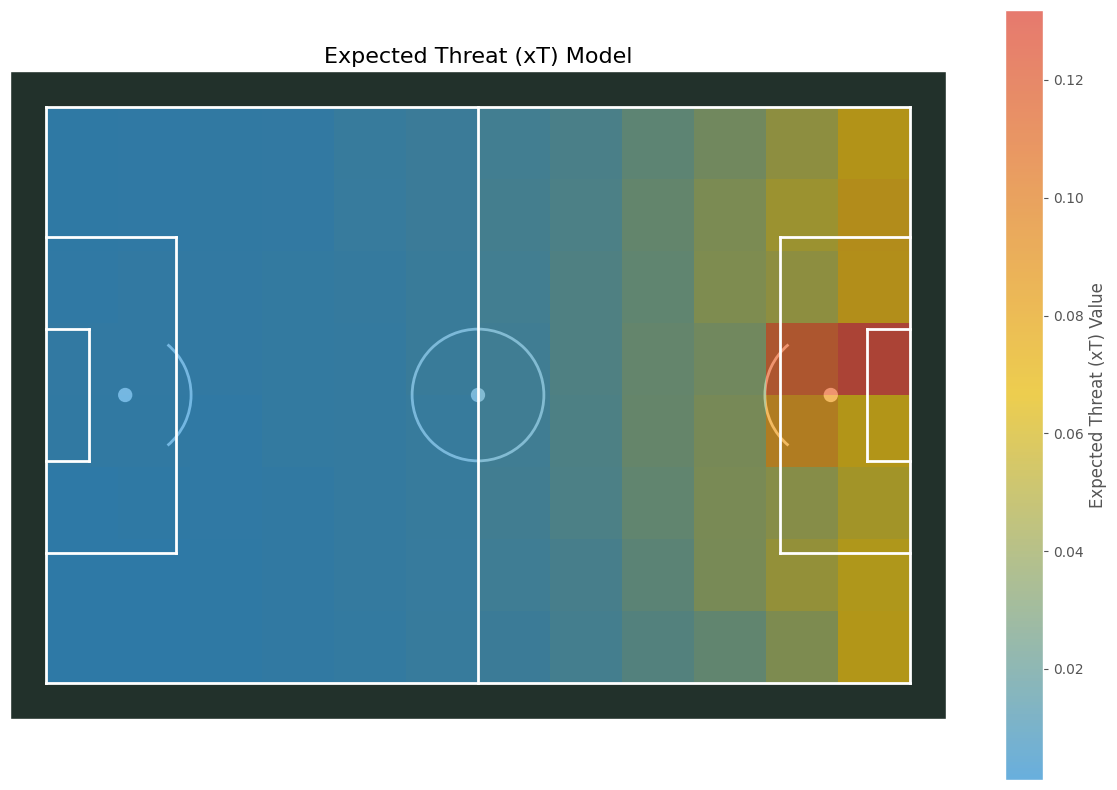

NameError: name 'export_dir' is not defined

In [12]:
# Visualize the xT grid as a heatmap
fig, ax = plt.subplots(figsize=(12, 8))
draw_pitch(ax)

# Create a colormap for xT values
cmap = LinearSegmentedColormap.from_list('xT_cmap', ['#3498db', '#f1c40f', '#e74c3c'])

# Create grid cells for xT values
# Create coordinates for the grid centers
x_centers = np.linspace(xt_model.cell_length_x/2, 120 - xt_model.cell_length_x/2, xt_model.n_grid_cells_x)
y_centers = np.linspace(xt_model.cell_length_y/2, 80 - xt_model.cell_length_y/2, xt_model.n_grid_cells_y)

# Create mesh grid
X, Y = np.meshgrid(x_centers, y_centers)

# Transpose grid for correct orientation
Z = xt_model.grid.T

# Plot heatmap
pcm = ax.pcolormesh(np.linspace(0, 120, xt_model.n_grid_cells_x + 1),
                   np.linspace(0, 80, xt_model.n_grid_cells_y + 1),
                   Z, shading='auto', alpha=0.7, cmap=cmap, zorder=1)

# Add colorbar
cbar = plt.colorbar(pcm, ax=ax)
cbar.set_label('Expected Threat (xT) Value', fontsize=12)

plt.title('Expected Threat (xT) Model', fontsize=16)
plt.tight_layout()
plt.show()

# Convert to base64 for API usage
xt_grid_b64 = fig_to_base64(fig)

# Create a sample API response for the xT model endpoint
xt_model_api_response = {
    "grid_size": {"x": xt_model.n_grid_cells_x, "y": xt_model.n_grid_cells_y},
    "pitch_dimensions": {"x": 120, "y": 80},
    "grid_values": xt_model.grid.tolist(),
    "visualization": xt_grid_b64
}

# Save the API response
with open(export_dir / 'xt_model_response.json', 'w') as f:
    json.dump(xt_model_api_response, f)

print(f"xT model visualization exported to {export_dir / 'xt_model_response.json'}")

In [ ]:
# Create a visualization of xT pass map
# This visualization would be returned by the /xt-analytics/pass-map endpoint

# Generate some sample passes with xT values
import random
np.random.seed(42)

# Generate 20 sample passes with varying xT values
sample_passes = []
for i in range(20):
    # Generate random start coordinates
    start_x = np.random.randint(10, 90)
    start_y = np.random.randint(10, 70)
    
    # Generate end coordinates with some bias toward goal
    end_x = min(start_x + np.random.randint(5, 30), 119)
    end_y = start_y + np.random.randint(-15, 15)
    end_y = max(1, min(79, end_y))
    
    # Calculate xT added
    start_xt = xt_model.get_value(start_x, start_y)
    end_xt = xt_model.get_value(end_x, end_y)
    xt_added = end_xt - start_xt
    
    # Only include progressive passes with positive xT
    if xt_added > 0:
        sample_passes.append({
            "player_id": np.random.randint(1, 6),
            "player_name": f"Player {np.random.randint(1, 6)}",
            "start_x": start_x,
            "start_y": start_y,
            "end_x": end_x,
            "end_y": end_y,
            "xt_value": xt_added
        })

# Create a visualization of the pass map
fig, ax = plt.subplots(figsize=(12, 8))
draw_pitch(ax)

# Define color map for xT values
norm = plt.Normalize(0, max(p["xt_value"] for p in sample_passes))
cmap = plt.cm.YlOrRd

# Plot each pass
for p in sample_passes:
    # Draw an arrow for each pass
    ax.annotate("", 
                xy=(p["end_x"], p["end_y"]),
                xytext=(p["start_x"], p["start_y"]),
                arrowprops=dict(arrowstyle="->", lw=2, 
                                color=cmap(norm(p["xt_value"])),
                                alpha=0.7))
    
    # Add a marker at the start point
    ax.plot(p["start_x"], p["start_y"], 'o', color='white', markersize=4)

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('xT Added', fontsize=12)

plt.title('Expected Threat (xT) Pass Map', fontsize=16)
plt.tight_layout()
plt.show()

# Convert to base64 for API usage
pass_map_b64 = fig_to_base64(fig)

# Create a sample API response for the xT pass map endpoint
xt_pass_map_api_response = {
    "passes": sample_passes,
    "visualization": pass_map_b64
}

# Save the API response
with open(export_dir / 'xt_pass_map_response.json', 'w') as f:
    json.dump(xt_pass_map_api_response, f)

print(f"xT pass map visualization exported to {export_dir / 'xt_pass_map_response.json'}")

## 2. Player Comparison Visualizations

Let's create visualizations for player comparisons that can be exported through the `/player-comparison` API endpoints.

In [ ]:
# Create a radar chart for player comparison
import matplotlib.pyplot as plt
import numpy as np

# Sample data for player comparison (radar chart)
player_names = ["Player A", "Player B"]
categories = ['Goals', 'Assists', 'xG', 'xA', 'Passes', 'Tackles', 'Interceptions', 'Dribbles']

# Values for each player (normalized from 0 to 1)
player_a_values = [0.8, 0.6, 0.75, 0.5, 0.65, 0.4, 0.3, 0.9]
player_b_values = [0.5, 0.8, 0.4, 0.7, 0.8, 0.6, 0.7, 0.5]

# Number of categories
N = len(categories)

# Create angles for each category
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Close the loop

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Add each player's data
player_a_values += player_a_values[:1]  # Close the loop
player_b_values += player_b_values[:1]  # Close the loop

# Plot data
ax.plot(angles, player_a_values, 'o-', linewidth=2, label=player_names[0], color='#1f77b4')
ax.fill(angles, player_a_values, alpha=0.25, color='#1f77b4')

ax.plot(angles, player_b_values, 'o-', linewidth=2, label=player_names[1], color='#ff7f0e')
ax.fill(angles, player_b_values, alpha=0.25, color='#ff7f0e')

# Set category labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)

# Remove radial labels and set y limits
ax.set_yticklabels([])
ax.set_ylim(0, 1)

# Add legend
ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.title('Player Comparison: Radar Chart', fontsize=15)
plt.tight_layout()
plt.show()

# Convert to base64 for API usage
radar_chart_b64 = fig_to_base64(fig)

# Create a sample API response for the player comparison radar endpoint
radar_api_response = {
    "players": [
        {
            "player_id": 1,
            "player_name": player_names[0],
            "team": "Team A",
            "metrics": dict(zip(categories, player_a_values[:-1]))
        },
        {
            "player_id": 2,
            "player_name": player_names[1],
            "team": "Team B",
            "metrics": dict(zip(categories, player_b_values[:-1]))
        }
    ],
    "metrics": categories,
    "metric_ranges": {cat: {"min": 0, "max": 1} for cat in categories},
    "normalized": True,
    "visualization": radar_chart_b64
}

# Save the API response
with open(export_dir / 'player_radar_comparison_response.json', 'w') as f:
    json.dump(radar_api_response, f)

print(f"Player radar comparison exported to {export_dir / 'player_radar_comparison_response.json'}")

In [ ]:
# Create a scatter plot for player comparison
import matplotlib.pyplot as plt
import numpy as np

# Sample data for player scatter plot
np.random.seed(42)
num_players = 50

# Generate random player data
player_data = []
for i in range(num_players):
    player_id = 1000 + i
    x_value = np.random.uniform(0, 1.0)  # e.g., xG per 90
    y_value = np.random.uniform(0, 1.2)  # e.g., xA per 90
    minutes = np.random.randint(500, 3000)
    
    position_groups = ["Forward", "Midfielder", "Defender", "Goalkeeper"]
    position_group = position_groups[i % 4]
    
    # Highlighted players
    is_highlighted = i < 5
    
    player_data.append({
        "player_id": player_id,
        "player_name": f"Player {player_id}",
        "team": f"Team {i % 10}",
        "position_group": position_group,
        "x_value": x_value,
        "y_value": y_value,
        "minutes": minutes,
        "highlighted": is_highlighted
    })

# Create the scatter plot
fig, ax = plt.subplots(figsize=(12, 8))

# Calculate averages
x_avg = sum(p["x_value"] for p in player_data) / len(player_data)
y_avg = sum(p["y_value"] for p in player_data) / len(player_data)

# Plot background players (not highlighted)
for pos_group in set(p["position_group"] for p in player_data):
    pos_players = [p for p in player_data if p["position_group"] == pos_group and not p["highlighted"]]
    if pos_players:
        x_values = [p["x_value"] for p in pos_players]
        y_values = [p["y_value"] for p in pos_players]
        ax.scatter(x_values, y_values, alpha=0.6, label=pos_group, s=50)

# Plot highlighted players with larger markers
highlighted = [p for p in player_data if p["highlighted"]]
if highlighted:
    x_values = [p["x_value"] for p in highlighted]
    y_values = [p["y_value"] for p in highlighted]
    ax.scatter(x_values, y_values, color='red', s=100, label='Highlighted Players', edgecolors='black')
    
    # Add labels for highlighted players
    for p in highlighted:
        ax.annotate(p["player_name"], (p["x_value"], p["y_value"]), 
                   xytext=(5, 5), textcoords='offset points', fontsize=8)

# Add quadrant lines and labels
ax.axvline(x=x_avg, color='gray', linestyle='--', alpha=0.7)
ax.axhline(y=y_avg, color='gray', linestyle='--', alpha=0.7)

# Add quadrant labels
ax.text(x_avg + 0.02, y_avg + 0.02, 'High xG, High xA', fontsize=10, ha='left', va='bottom')
ax.text(x_avg - 0.02, y_avg + 0.02, 'Low xG, High xA', fontsize=10, ha='right', va='bottom')
ax.text(x_avg + 0.02, y_avg - 0.02, 'High xG, Low xA', fontsize=10, ha='left', va='top')
ax.text(x_avg - 0.02, y_avg - 0.02, 'Low xG, Low xA', fontsize=10, ha='right', va='top')

ax.set_xlabel('xG per 90', fontsize=12)
ax.set_ylabel('xA per 90', fontsize=12)
ax.set_title('Player Comparison: xG vs xA per 90', fontsize=15)
ax.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Convert to base64 for API usage
scatter_plot_b64 = fig_to_base64(fig)

# Create a sample API response for the scatter plot endpoint
scatter_api_response = {
    "players": player_data,
    "x_metric": "xG per 90",
    "y_metric": "xA per 90",
    "x_average": x_avg,
    "y_average": y_avg,
    "min_minutes": 500,
    "position_group": None,
    "visualization": scatter_plot_b64
}

# Save the API response
with open(export_dir / 'player_scatter_comparison_response.json', 'w') as f:
    json.dump(scatter_api_response, f)

print(f"Player scatter comparison exported to {export_dir / 'player_scatter_comparison_response.json'}")

## 3. Matchup Analysis Visualizations

Let's create visualizations for matchup analysis that can be exported through the `/matchup-analysis` API endpoints.

In [ ]:
# Create a visualization for head-to-head matchup analysis
import matplotlib.pyplot as plt
import numpy as np

# Sample head-to-head data
team1_name = "Team A"
team2_name = "Team B"

# Historical match results
dates = ["2023-01-15", "2023-03-10", "2023-05-22", "2023-08-05", "2023-11-19"]
team1_scores = [2, 1, 2, 0, 3]
team2_scores = [1, 1, 0, 2, 1]

# Create a figure with multiple subplots
fig = plt.figure(figsize=(15, 10))

# 1. Historical Match Results
ax1 = plt.subplot2grid((2, 2), (0, 0))
matches = [f"{d}\n{team1_name} {s1}-{s2} {team2_name}" for d, s1, s2 in zip(dates, team1_scores, team2_scores)]
colors = ['green' if s1 > s2 else 'red' if s1 < s2 else 'gray' for s1, s2 in zip(team1_scores, team2_scores)]
ax1.bar(range(len(matches)), [1] * len(matches), color=colors)
ax1.set_xticks(range(len(matches)))
ax1.set_xticklabels(matches, rotation=45, ha='right')
ax1.set_yticks([])
ax1.set_title('Historical Match Results', fontsize=12)
for i, (s1, s2) in enumerate(zip(team1_scores, team2_scores)):
    result = f"{s1} - {s2}"
    ax1.text(i, 0.5, result, ha='center', va='center', fontsize=12, color='white', fontweight='bold')

# 2. Head-to-Head Summary
ax2 = plt.subplot2grid((2, 2), (0, 1))
team1_wins = sum(1 for s1, s2 in zip(team1_scores, team2_scores) if s1 > s2)
team2_wins = sum(1 for s1, s2 in zip(team1_scores, team2_scores) if s1 < s2)
draws = sum(1 for s1, s2 in zip(team1_scores, team2_scores) if s1 == s2)

summary_labels = [f"{team1_name} Wins", "Draws", f"{team2_name} Wins"]
summary_values = [team1_wins, draws, team2_wins]
summary_colors = ['#1f77b4', '#7f7f7f', '#ff7f0e']

ax2.pie(summary_values, labels=summary_labels, colors=summary_colors, autopct='%1.1f%%', startangle=90)
ax2.set_title('Head-to-Head Summary', fontsize=12)

# 3. Comparative Metrics
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
metrics = ['Possession', 'Shots', 'Shots on Target', 'Passes', 'Pass Accuracy', 'PPDA', 'Chances Created']
team1_metrics = [52.3, 12.5, 4.8, 450, 84.2, 9.3, 2.3]
team2_metrics = [47.7, 10.8, 3.9, 410, 81.5, 10.5, 1.8]

x = np.arange(len(metrics))
width = 0.35

ax3.bar(x - width/2, team1_metrics, width, label=team1_name, color='#1f77b4')
ax3.bar(x + width/2, team2_metrics, width, label=team2_name, color='#ff7f0e')

ax3.set_xticks(x)
ax3.set_xticklabels(metrics)
ax3.legend()
ax3.set_title('Comparative Metrics', fontsize=12)

plt.suptitle(f'Head-to-Head Analysis: {team1_name} vs {team2_name}', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Convert to base64 for API usage
head_to_head_b64 = fig_to_base64(fig)

# Create a sample API response for the head-to-head endpoint
head_to_head_api_response = {
    "team1": {
        "id": 1,
        "name": team1_name
    },
    "team2": {
        "id": 2,
        "name": team2_name
    },
    "summary": {
        "matches_played": len(dates),
        "team1_wins": team1_wins,
        "team2_wins": team2_wins,
        "draws": draws,
        "team1_goals": sum(team1_scores),
        "team2_goals": sum(team2_scores)
    },
    "historical_matches": [
        {
            "match_id": 1000 + i,
            "date": date,
            "competition": "League A" if i % 2 == 0 else "Cup B",
            "home_team": team1_name if i % 2 == 0 else team2_name,
            "away_team": team2_name if i % 2 == 0 else team1_name,
            "score": f"{s1}-{s2}",
            "winner": "team1" if s1 > s2 else "team2" if s2 > s1 else "draw"
        }
        for i, (date, s1, s2) in enumerate(zip(dates, team1_scores, team2_scores))
    ],
    "comparative_metrics": {
        "possession": {
            "team1": team1_metrics[0],
            "team2": team2_metrics[0]
        },
        "shots": {
            "team1": team1_metrics[1],
            "team2": team2_metrics[1]
        },
        "shots_on_target": {
            "team1": team1_metrics[2],
            "team2": team2_metrics[2]
        },
        "passes": {
            "team1": team1_metrics[3],
            "team2": team2_metrics[3]
        },
        "pass_accuracy": {
            "team1": team1_metrics[4],
            "team2": team2_metrics[4]
        },
        "ppda": {
            "team1": team1_metrics[5],
            "team2": team2_metrics[5]
        },
        "chances_created": {
            "team1": team1_metrics[6],
            "team2": team2_metrics[6]
        }
    },
    "visualization": head_to_head_b64
}

# Save the API response
with open(export_dir / 'head_to_head_response.json', 'w') as f:
    json.dump(head_to_head_api_response, f)

print(f"Head-to-head analysis exported to {export_dir / 'head_to_head_response.json'}")

In [ ]:
# Create a visualization for team style comparison
import matplotlib.pyplot as plt
import numpy as np

# Sample team style data
team_name = "Team A"
style_metrics = [
    "Possession (%)",
    "Build-up Speed",
    "Width",
    "Directness",
    "Pressing Intensity",
    "Defensive Line Height",
    "Counter-Attack Frequency",
    "Set Piece Reliance"
]

# Values for the team and league average (0-10 scale)
team_values = [7.2, 5.8, 8.5, 6.2, 8.7, 7.5, 4.2, 3.8]
league_avg_values = [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
rival_team_values = [4.5, 7.2, 4.3, 8.1, 3.5, 4.2, 7.8, 6.9]

# Create radar chart for team style
# Number of categories
N = len(style_metrics)

# Create angles for each category
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Close the loop

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Add each dataset
# Team values
team_values_plot = team_values + team_values[:1]  # Close the loop
ax.plot(angles, team_values_plot, 'o-', linewidth=2, label=team_name, color='#1f77b4')
ax.fill(angles, team_values_plot, alpha=0.25, color='#1f77b4')

# League average
league_avg_values_plot = league_avg_values + league_avg_values[:1]  # Close the loop
ax.plot(angles, league_avg_values_plot, 'o-', linewidth=2, label='League Average', color='#7f7f7f')
ax.fill(angles, league_avg_values_plot, alpha=0.1, color='#7f7f7f')

# Rival team
rival_team_values_plot = rival_team_values + rival_team_values[:1]  # Close the loop
ax.plot(angles, rival_team_values_plot, 'o-', linewidth=2, label='Rival Team', color='#ff7f0e')
ax.fill(angles, rival_team_values_plot, alpha=0.25, color='#ff7f0e')

# Set category labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(style_metrics)

# Set y-axis limits
ax.set_ylim(0, 10)
ax.set_yticks([2, 4, 6, 8, 10])
ax.set_yticklabels(['2', '4', '6', '8', '10'])

# Add legend
ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.title('Team Style Comparison', fontsize=15)
plt.tight_layout()
plt.show()

# Convert to base64 for API usage
team_style_b64 = fig_to_base64(fig)

# Create a sample API response for the team style comparison endpoint
team_style_api_response = {
    "team": {
        "id": 1,
        "name": team_name
    },
    "competition_id": 1,
    "season_id": 1,
    "style_metrics": style_metrics,
    "team_style": dict(zip(style_metrics, team_values)),
    "comparisons": [
        {
            "team_id": None,
            "team_name": "League Average",
            "style": dict(zip(style_metrics, league_avg_values))
        },
        {
            "team_id": 2,
            "team_name": "Rival Team",
            "style": dict(zip(style_metrics, rival_team_values))
        }
    ],
    "visualization": team_style_b64
}

# Save the API response
with open(export_dir / 'team_style_comparison_response.json', 'w') as f:
    json.dump(team_style_api_response, f)

print(f"Team style comparison exported to {export_dir / 'team_style_comparison_response.json'}")

## 4. Positional Analysis Visualizations

Let's create visualizations for positional analysis that can be exported through the `/positional-analysis` API endpoints.

In [ ]:
# Create a visualization for zone effectiveness analysis
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

# Sample zone effectiveness data
# Create a 4x6 grid of zones with effectiveness scores
np.random.seed(42)
zones = []
for i in range(4):  # 4 vertical zones
    for j in range(6):  # 6 horizontal zones
        zone_x = j * 20
        zone_y = i * 20
        
        # Effectiveness increases as we move up the pitch
        effectiveness = (j + 1) * 15
        
        # Add some variation
        variation = np.random.uniform(-10, 10)
        effectiveness = max(0, min(100, effectiveness + variation))
        
        zones.append({
            "zone_id": f"{i+1}_{j+1}",
            "x_start": zone_x,
            "y_start": zone_y,
            "x_end": zone_x + 20,
            "y_end": zone_y + 20,
            "effectiveness": effectiveness,
            "xt_generated": (j + 1) * (i + 1) * 0.15,
            "actions": (j + 1) * (i + 1) * 10
        })

# Create a heatmap visualization
fig, ax = plt.subplots(figsize=(12, 8))
draw_pitch(ax)

# Create a colormap
cmap = plt.cm.YlOrRd
norm = plt.Normalize(0, 100)

# Draw each zone as a rectangle with color based on effectiveness
for zone in zones:
    rect = patches.Rectangle(
        (zone["x_start"], zone["y_start"]),
        zone["x_end"] - zone["x_start"],
        zone["y_end"] - zone["y_start"],
        linewidth=1,
        edgecolor='gray',
        facecolor=cmap(zone["effectiveness"]/100),
        alpha=0.7
    )
    ax.add_patch(rect)
    
    # Add effectiveness score text
    ax.text(
        (zone["x_start"] + zone["x_end"]) / 2,
        (zone["y_start"] + zone["y_end"]) / 2,
        f"{zone['effectiveness']:.1f}",
        ha='center',
        va='center',
        color='black' if zone["effectiveness"] < 50 else 'white',
        fontweight='bold'
    )

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Zone Effectiveness (%)', fontsize=12)

plt.title('Zone Effectiveness Analysis', fontsize=16)
plt.tight_layout()
plt.show()

# Convert to base64 for API usage
zone_effectiveness_b64 = fig_to_base64(fig)

# Create a sample API response for the zone effectiveness endpoint
zone_effectiveness_api_response = {
    "team_id": 1,
    "competition_id": 1,
    "match_id": None,
    "pitch_zones": zones,
    "pitch_dimensions": {
        "length": 120,
        "width": 80
    },
    "visualization": zone_effectiveness_b64
}

# Save the API response
with open(export_dir / 'zone_effectiveness_response.json', 'w') as f:
    json.dump(zone_effectiveness_api_response, f)

print(f"Zone effectiveness analysis exported to {export_dir / 'zone_effectiveness_response.json'}")

In [ ]:
# Create a visualization for player heat map
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.colors as mcolors

# Sample player action data
np.random.seed(42)
num_actions = 150

# Generate sample action locations with position bias for a midfielder
actions = []
x_mean, y_mean = 60, 40  # Middle of the pitch for a midfielder

# Generate semi-random action locations with position bias
for i in range(num_actions):
    # Add some noise to the position
    x = max(0, min(120, x_mean + np.random.normal(0, 20)))
    y = max(0, min(80, y_mean + np.random.normal(0, 15)))
    
    # Determine event type
    event_types = ["Pass", "Shot", "Carry", "Ball Receipt", "Pressure"]
    weights = [0.6, 0.05, 0.2, 0.1, 0.05]
    action_type = np.random.choice(event_types, p=weights)
    
    # Add the action
    actions.append({
        "x": x,
        "y": y,
        "type": action_type,
        "minute": np.random.randint(1, 90),
        "outcome": np.random.choice(["Successful", "Unsuccessful"], p=[0.8, 0.2])
    })

# Create a heatmap visualization
fig, ax = plt.subplots(figsize=(12, 8))
draw_pitch(ax)

# Extract x and y coordinates
x = [action["x"] for action in actions]
y = [action["y"] for action in actions]

# Create a 2D histogram
heatmap, xedges, yedges = np.histogram2d(x, y, bins=[24, 16], range=[[0, 120], [0, 80]])

# Smooth the heatmap
sigma = 1.0
heatmap = gaussian_filter(heatmap, sigma)

# Create a custom colormap
colors = [(0,0,0,0), (0,0.5,1,0.5), (0,0.75,1,0.8), (1,1,0,1)]
custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)

# Plot the heatmap
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
im = ax.imshow(heatmap.T, extent=extent, origin='lower', cmap=custom_cmap, aspect='auto', alpha=0.7)

# Add a colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Action Density', fontsize=12)

# Plot individual actions as scatter points
for action_type, color in zip(["Pass", "Shot", "Carry", "Ball Receipt", "Pressure"],
                             ['blue', 'red', 'green', 'purple', 'orange']):
    action_x = [action["x"] for action in actions if action["type"] == action_type]
    action_y = [action["y"] for action in actions if action["type"] == action_type]
    ax.scatter(action_x, action_y, color=color, alpha=0.6, s=30, label=action_type)

plt.title('Player Action Heat Map', fontsize=16)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=5)
plt.tight_layout()
plt.show()

# Convert to base64 for API usage
player_heatmap_b64 = fig_to_base64(fig)

# Create a sample API response for the player heat map endpoint
player_heatmap_api_response = {
    "player": {
        "player_id": 1,
        "player_name": "John Doe",
        "team": "Team A",
        "position": "Midfielder"
    },
    "match_id": None,
    "competition_id": 1,
    "event_type": "all",
    "actions": actions,
    "action_count": len(actions),
    "visualization": player_heatmap_b64
}

# Save the API response
with open(export_dir / 'player_heatmap_response.json', 'w') as f:
    json.dump(player_heatmap_api_response, f)

print(f"Player heat map analysis exported to {export_dir / 'player_heatmap_response.json'}")

## 5. Summary and Export for API

Now that we've created a range of visualizations that match our API endpoints, let's export a consolidated set of sample responses that can be used by the API.

In [ ]:
# Create a consolidated API responses file
# First, let's create an export directory if it doesn't exist
export_dir = Path("data_cache/visualization_exports")
export_dir.mkdir(exist_ok=True, parents=True)

api_responses = {
    "xt_analytics": {
        "model": xt_model_api_response,
        "pass_map": xt_pass_map_api_response
    },
    "player_comparison": {
        "radar": radar_api_response,
        "scatter_plot": scatter_api_response
    },
    "matchup_analysis": {
        "head_to_head": head_to_head_api_response,
        "team_style": team_style_api_response
    },
    "positional_analysis": {
        "zone_effectiveness": zone_effectiveness_api_response,
        "player_heat_map": player_heatmap_api_response
    }
}

# Save the consolidated API responses
with open(export_dir / 'api_visualization_examples.json', 'w') as f:
    json.dump(api_responses, f)

print(f"Consolidated API visualization examples exported to {export_dir / 'api_visualization_examples.json'}")

# Also save a README file explaining how to use these visualizations
readme_content = """# Football API Visualization Examples

This directory contains example visualizations that can be returned by the Football Insights API endpoints.
Each JSON file contains sample API responses with base64-encoded visualizations that can be displayed in a web application.

## Available Visualizations

1. **Expected Threat (xT) Analytics**
   - xT Model Grid Visualization
   - xT Pass Map Visualization

2. **Player Comparison**
   - Radar Chart for Player Comparison
   - Scatter Plot for Player Comparison

3. **Matchup Analysis**
   - Head-to-Head Analysis
   - Team Style Comparison

4. **Positional Analysis**
   - Zone Effectiveness Analysis
   - Player Heat Map

## Usage

These visualizations can be directly included in web applications by embedding the base64-encoded images:

```html
<img src="data:image/png;base64,{visualization_base64}" alt="Visualization">
```

Or they can be used as templates to create similar visualizations for the actual API responses.
"""

with open(export_dir / 'README.md', 'w') as f:
    f.write(readme_content)

print(f"README file created at {export_dir / 'README.md'}")